In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
# %matplotlib widget

def get_file_path(isotope: str, temp: float | str, ch: int, hv: int, dir: str):
    temp_str = temp if isinstance(temp, str) else f'{int(temp)}'
    return f"../data/{dir}/{isotope}/t_{temp_str}/ch_{ch}/hv_{hv}.csv"

def load_spec(isotope: str, temp: float, ch: int, hv: int, dir: str) -> np.ndarray:
    filepath = get_file_path(isotope, temp, ch, hv, dir)
    df = pd.read_csv(filepath)
    
    df = pd.read_csv(filepath)
    exp_times = df.values[:, 0]
    total_exposure = np.sum(exp_times)
    spec_exposures = df.values[:, 4:]
    spec = np.sum(spec_exposures * np.tile(exp_times, (spec_exposures.shape[1], 1)).T, axis=0) / total_exposure
    return spec

def load_partial_specs(isotope: str, temp: float, ch: int, hv: int, dir: str) -> np.ndarray:
    filepath = get_file_path(isotope, temp, ch, hv, dir)
    df = pd.read_csv(filepath)
    total_exposure = np.sum(df.values[:, 0])
    spec_exposures = df.values[:, 4:]
    return spec_exposures

channels = np.arange(0, 256)

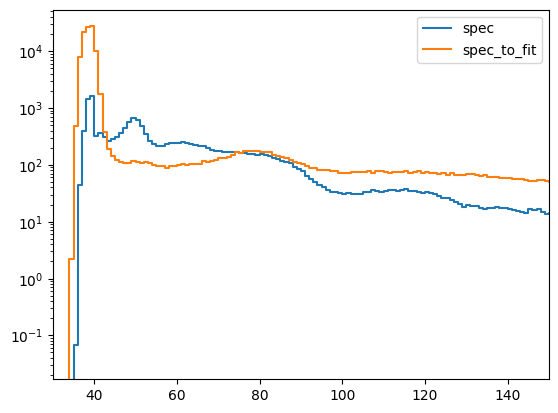

[ 0.30379747  0.29995727 37.54545452]


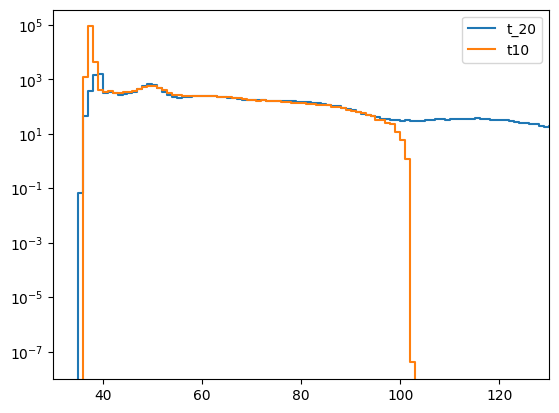

In [2]:
from typing import Tuple
from scipy.optimize import minimize
temp = 20

noise_peak_ch = 38

# spec = load_spec('eu152', temp, 0, 150)
# spec_to_fit = load_spec('eu152', 40, 0, 150)
spec = load_spec('ra226', 25, 0, 130, 't')
spec_to_fit = load_spec('ra226', 0, 0, 180, 't')

plt.figure()
plt.step(channels, spec, label=f'spec')
plt.step(channels, spec_to_fit, label='spec_to_fit')
plt.legend()
plt.yscale('log')
plt.xlim(30, 150)
plt.show()

def scaled_spec(spec: np.ndarray, x_scale: float, y_scale: float, origin: float) -> Tuple[np.ndarray, np.ndarray]:
    new_channels = (channels - origin) / x_scale + origin
    new_spec = np.interp(new_channels, channels, spec) / y_scale
    return new_channels, new_spec


def fit_spec(spec: np.ndarray, ref_spec: np.ndarray) -> Tuple[float, float, float]:
    def error_func(args):
        x_scale, y_scale, origin = args
        new_channels, new_spec = scaled_spec(spec, x_scale, y_scale, origin)
        fit_from = noise_peak_ch + 8
        original_spec = ref_spec[fit_from:130]
        fit_spec = new_spec[fit_from:130]
        error = np.sum((original_spec - fit_spec)**2)
        return error

    result = minimize(error_func, [1.0, 1.0, 38], method='Nelder-Mead')
    return result.x

result = fit_spec(spec_to_fit, spec)
print(result)
plt.figure()
plt.step(channels, spec, label=f't_{temp}')
new_channels, new_spec = scaled_spec(spec_to_fit, *result)
plt.step(channels, new_spec, label='t10')
plt.legend()
plt.yscale('log')
plt.xlim(30, 130)
plt.show()

## Rescaling for one isotope

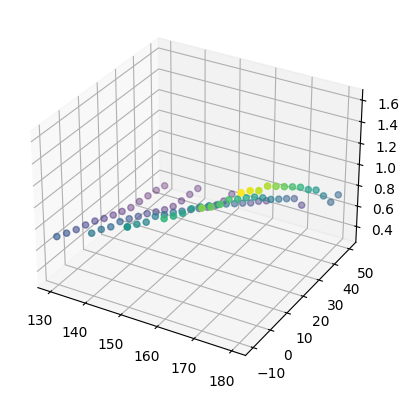

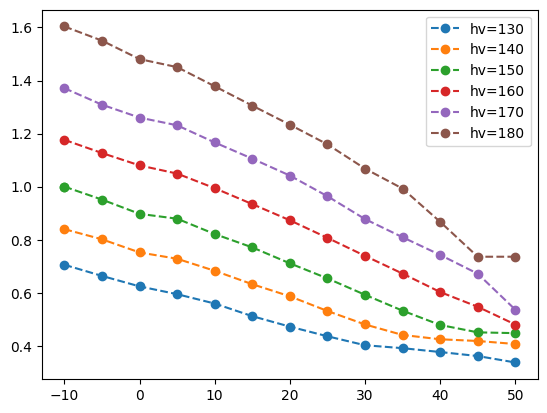

In [4]:
import os

def analyze_isotope(isotope: str, dir: str, should_plot=False):
    # Initialize arrays where the fit results will be stored
    fit_hvs = []
    fit_temps = []
    fit_ks = []
    fit_chi0s = []
    fit_yscales = []
    fit_specs = []

    # Find available temperatures
    temp_dirs = os.listdir(f'../data/{dir}/{isotope}')
    all_temps = []
    for temp_dir in temp_dirs:
        if temp_dir.startswith('t_'):
            all_temps.append(int(temp_dir[2:]))
    all_temps = sorted(all_temps)
    # all_temps = all_temps[::-1]

    # Find the first spectrum
    first_temp = all_temps[0]
    hv_files = os.listdir(f"../data/{dir}/{isotope}/t_{first_temp}/ch_0")
    first_hv = int(hv_files[0].split('_')[1].split('.')[0])
    first_spec = load_spec(isotope, first_temp, 0, first_hv, dir)
    fit_hvs.append(first_hv)
    fit_temps.append(first_temp)
    fit_specs.append(first_spec)
    fit_ks.append(1.0)
    fit_chi0s.append(np.nan)
    fit_yscales.append(1.0)

    def find_nearest_spec_fit(hv: int, temp: float) -> Tuple[np.ndarray, int, float]:
        # return fit_specs[0], fit_ks[0], fit_yscales[0]
        nearest_spec_i = 0
        nearest_spec_dst = np.inf
        for i in range(len(fit_hvs)):
            dst = abs(fit_hvs[i] - hv) * 5 + abs(fit_temps[i] - temp) * 4
            if dst < nearest_spec_dst:
                nearest_spec_dst = dst
                nearest_spec_i = i
        
        return fit_specs[nearest_spec_i], fit_ks[nearest_spec_i], fit_yscales[nearest_spec_i]
    # Fit the rest of the spectra
    for temp in all_temps:
        for hv in range(130, 181, 10):
            if not os.path.exists(get_file_path(isotope, temp, 0, hv, dir)):
                continue

            # Find closest reference spec
            ref_spec, ref_k, ref_yscale = find_nearest_spec_fit(hv, temp)
            
            # Fit the spectrum
            spec = load_spec(isotope, temp, 0, hv, dir)
            k, yscale, chi0 = fit_spec(spec, ref_spec)
            fit_hvs.append(hv)
            fit_temps.append(temp)
            fit_ks.append(k * ref_k)
            fit_chi0s.append(chi0)
            fit_yscales.append(yscale * ref_yscale)
            fit_specs.append(spec)

            if should_plot:
                plt.figure()
                plt.xlim(46, 130)
                plt.step(channels, ref_spec, label=f't_{temp}')
                new_channels, new_spec = scaled_spec(spec, k, yscale, chi0)
                plt.step(channels, new_spec, label='fit')
                plt.legend()
                plt.yscale('log')
                plt.ylim(1, None)
                plt.title(f'{isotope} t_{temp} hv_{hv}')
                plt.show()
    
    return np.array(fit_hvs), np.array(fit_temps), np.array(fit_ks), np.array(fit_chi0s), np.array(fit_yscales)


ra_hvs, ra_temps, ra_ks, ra_chi0s, ra_yscales = analyze_isotope('am241', 't', False)

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(ra_hvs, ra_temps, 1/ra_ks, c=1/ra_ks, marker='o')
plt.show()

plt.figure()
ra_hvs_unique = np.unique(ra_hvs)
for hv in ra_hvs_unique:
    mask = ra_hvs == hv
    plt.plot(ra_temps[mask], 1/ra_ks[mask], '--o', label=f'hv={hv}')
# plt.scatter(ra_temps, 1/np.array(ra_ks), c=ra_temps, marker='o')
plt.legend()
plt.show()

In [5]:
ra_hvs, ra_temps, ra_ks, ra_chi0s, ra_yscales = analyze_isotope('ra226', 't', False)
am_hvs, am_temps, am_ks, am_chi0s, am_yscales = analyze_isotope('am241', 't', False)
